# Tutorial Assignment 3

<br>
<br>


## Import packages

In [1]:
import os
import yaml
import common
import gensim
import matplotlib
import numpy as np
import p2vmap
import pandas as pd
import sklearn.manifold
import torch
import torch.nn
import torch.nn.functional
import torch.utils.tensorboard
import seaborn as sns
import plotly

matplotlib.rcParams["image.cmap"] = "jet"

In [2]:
%load_ext tensorboard

In [3]:
%reload_ext tensorboard

<br>
<br>

## Input

In [4]:
PATH_DATA = r"C:\\Users\Lodew\Documents\Minor_LFBD\Module 3"

In [5]:
def read_yaml(filepath):
        """
        Read the YAML file at specified location

        return the yaml data on success
        raise an exception upon failure reading/load the file
        """
        try:
            with open(filepath) as fin:
                data = yaml.load(fin, Loader=yaml.SafeLoader)
        except yaml.YAMLError as exc:
            _print("Failed to read {}".format(filepath))
            _print("Error: {}".format(exc))
            return None
        else:
            return data 

<br>
<br>

## Load data

In [6]:
config_p2vmap = read_yaml(f"{PATH_DATA}\\config-p2vmap.yaml")
config_p2vmap

{'trainer': {'epochs': 3},
 'p2v': {'size': 20},
 'data': {'data_streamer': {'variable_basket': 'basket',
   'variable_product': 'product',
   'batch_size': 8192,
   'n_negative_samples': 10,
   'power': 0.75,
   'shuffle': True,
   'allow_context_collisions': False},
  'split': {'test_size': 0.05},
  'train': {'batch_size': 1024, 'shuffle': True, 'drop_last': True},
  'valid': {'batch_size': 4096, 'shuffle': False, 'drop_last': False},
  'test': {'batch_size': 4096, 'shuffle': False, 'drop_last': False}}}

In [7]:
config_w2v = read_yaml(f"{PATH_DATA}\\config-w2v.yaml")
config_w2v

{'baskets_df_to_list': {'min_basket_size': 3,
  'shuffle': True,
  'to_string': True,
  'seed': 123},
 'Word2Vec': {'vector_size': 20,
  'window': 1000,
  'min_count': 1,
  'alpha': 0.025,
  'min_alpha': 0.0001,
  'sample': 0.001,
  'sg': 1,
  'negative': 10,
  'epochs': 3},
 'TSNE': {'n_components': 2,
  'n_iter': 4000,
  'perplexity': 5,
  'init': 'pca',
  'angle': 0.5,
  'random_state': 123,
  'verbose': 0}}

In [8]:
baskets = pd.read_parquet(f"{PATH_DATA}\\market-baskets.parquet")
del baskets["customer"]

In [9]:
product = pd.DataFrame(
    {
        "product": list(range(300)),
        "category": np.repeat(range(20), 15),
    }
)

<br>
<br>


## Baseline model using Gensim

### Produce basket list

In [10]:
basket_list = p2vmap.baskets_df_to_list(
    x=baskets, **config_w2v["baskets_df_to_list"]
)

### Word2Vec model

In [11]:
w2v = gensim.models.Word2Vec(basket_list, **config_w2v["Word2Vec"])

In [12]:
product_embedding, _, _ = p2vmap.gensim_to_pandas(w2v)
product_embedding.head()

0         1         2         3         4         5         6  \
product                                                                         
0        0.352302  0.760462 -0.438687  0.473251 -0.218506  0.161197 -0.409525   
1        0.357175  0.739345 -0.406749  0.476441 -0.195618  0.173901 -0.405403   
2        0.359735  0.755714 -0.393077  0.467488 -0.184788  0.179586 -0.412169   
3        0.378028  0.775532 -0.406412  0.473640 -0.198837  0.165707 -0.400018   
4        0.344507  0.728985 -0.419354  0.478057 -0.206193  0.218468 -0.391383   

                7         8         9        10        11        12        13  \
product                                                                         
0       -0.494985 -0.290596  0.516981  0.526558 -0.247735  0.108953  0.550671   
1       -0.510624 -0.267463  0.532405  0.558982 -0.264903  0.098173  0.554497   
2       -0.545016 -0.295420  0.514626  0.560368 -0.254850  0.135431  0.566964   
3       -0.495790 -0.255418  0.509252  0.538676 -0.258420  0.120283  0.567958   
4       -0.535815 -0.266627  0.496978  0.571159 -0.255602  0.141021  0.574102   

               14        15        16        17        18        19  
product                                                              
0        0.453510  0.053071 -0.360060 -0.271745  0.765689 -0.409237  
1        0.472131  0.083991 -0.379960 -0.254298  0.737451 -0.397352  
2        0.443636  0.103931 -0.357553 -0.267037  0.720474 -0.405114  
3        0.443950  0.095118 -0.393812 -0.274205  0.749409 -0.414540  
4        0.499311  0.114018 -0.370297 -0.294400  0.800342 -0.390541

### Baseline product map

In [13]:
x = product_embedding.values
x /= np.linalg.norm(x, axis=1)[:, np.newaxis]
res_tsne = sklearn.manifold.TSNE(**config_w2v["TSNE"]).fit_transform(x)

In [14]:
tsne_map_xy = pd.DataFrame(
    res_tsne,
    index=product[["category", "product"]].set_index(["category", "product"]).index,
    columns=["x", "y"],
).reset_index()

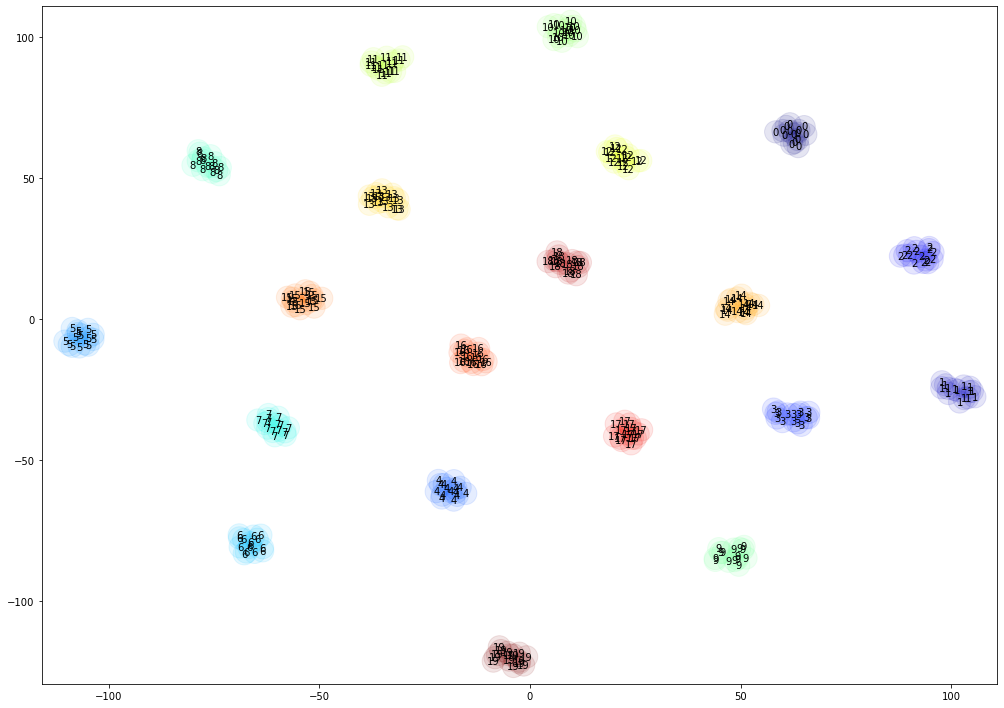

In [15]:
p2vmap.plot_tsne(tsne_map_xy, plotlabels=True, scatter=0)

### Baseline silhouette score

In [16]:
baseline_silhouette_score = sklearn.metrics.silhouette_score(
    res_tsne, product['category'].values, metric='euclidean'
)
baseline_silhouette_score

0.9052594

<br>
<br>

## Data streamer

### initialize streamer

In [17]:
data_stream_p2v = p2vmap.DataStreamP2V(
    data=baskets,
    variable_basket="basket",
    variable_product="product",
    batch_size=256,
    shuffle=True,
    n_negative_samples=10,
)

In [18]:
data_stream_p2v

<br>
<br>

## PyTorch

### Building data  loader function

In [19]:
def build_data_loader(streamer, config):
    # build numpy arrays for full dataset
    streamer.reset_iterator()
    list_ce = []
    list_co = []
    list_ns = []
    while True:
        try:
            ce, co, ns = streamer.generate_batch()
            list_ce.append(ce)
            list_co.append(co)
            list_ns.append(ns)
        except:
            break
    ce = np.hstack(list_ce)
    co = np.hstack(list_co)
    ns = np.vstack(list_ns)

    # train/validation split
    ce_t, ce_v, co_t, co_v, ns_t, ns_v = sklearn.model_selection.train_test_split(
        ce, co, ns, **config["split"]
    )

    # build data loader
    dl_train = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            torch.LongTensor(ce_t),
            torch.LongTensor(co_t),
            torch.LongTensor(ns_t),
        ),
        **config["train"],
    )
    dl_val = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            torch.LongTensor(ce_v),
            torch.LongTensor(co_v),
            torch.LongTensor(ns_v),
        ),
        **config["valid"],
    )
    return dl_train, dl_val

In [20]:
dl_train, dl_validation = build_data_loader(
    streamer=data_stream_p2v,
    config=config_p2vmap["data"],
)

In [21]:
dl_train

In [22]:
dl_validation

why shuffling: otherwise patterns like christmas will always make the model not precise
why not shuffling: you do not change weights in validating (weights are frozen after training) so it does not matter if you shuffle. It takes more effort so no need. 
spiral dataset for training steps!!!
provide arguments for categorial labels! 
reason: co-accurance is low, very high similarity so same category
You can also use clustering, how many clusters (same as 25???) 

How to make a baseline? 

### Building the model

In [23]:
class P2V(torch.nn.Module):
    def __init__(self, n_products, size):
        super().__init__()
        
        # define (and initialise) the weights of the NN
        
        self.n_products = n_products
        self.size = size
        
        self.wi = torch.nn.Embedding(self.n_products, self.size, sparse=True)
        with torch.no_grad():
            self.wi.weight.uniform_(-0.025, 0.025)
            
        self.wo = torch.nn.Embedding(self.n_products, self.size, sparse=True)
        with torch.no_grad():
            self.wo.weight.uniform_(-0.025, 0.025)        
        
        
    def forward(self, center, context, negative_samples):
        
        # 1) the generated indices are the input to `forward`
        # 2) embed the indices using `wi` and `wo` (for the full batch)
        # 3) compute the logins
        # 4) compute the loss
        
        # 1 and 2)
        wi_center = self.wi(center)
        wo_positive_samples = self.wo(context)
        wo_negative_samples = self.wo(negative_samples)
        
        # 3)
        logits_positive_samples = torch.einsum("ij,ij->i", (wi_center, wo_positive_samples))
        logits_negative_samples = torch.einsum("ik,ijk->ij", (wi_center, wo_negative_samples))
        
        # 4) 
        loss_positive_samples = torch.nn.functional.binary_cross_entropy_with_logits(
            input=logits_positive_samples,
            target=torch.ones_like(logits_positive_samples),
            reduction="sum",
        )
        
        loss_negative_samples = torch.nn.functional.binary_cross_entropy_with_logits(
            input=logits_negative_samples,
            target=torch.zeros_like(logits_negative_samples),
            reduction="sum",
        )
        
        n_samples = logits_positive_samples.shape[0] * (logits_negative_samples.shape[1] + 1)
        
        loss = (loss_positive_samples + loss_negative_samples) / n_samples
        
        return loss

### Building the modeltrainer

In [24]:
class TrainerP2V:
    def __init__(self, model, train, validation, path, n_batch_log=1000):
        self.model = model # P2V model
        self.train = train # dl_train
        self.validation = validation # dl_validation
        self.optimizer = torch.optim.SparseAdam(params=list(self.model.parameters()))
        self.path = path
        os.makedirs(f"{self.path}\\weights")
        self.writer_train = torch.utils.tensorboard.SummaryWriter(
            f"{self.path}\\runs\\train"
        )
        self.writer_val = torch.utils.tensorboard.SummaryWriter(f"{self.path}\\runs\\val")
        self.n_batch_log = n_batch_log
        self.global_batch = 0
        self.epoch = 0
        self.batch = 0

    def fit(self, n_epochs):

        for _ in range(n_epochs):
            print(f"epoch = {self.epoch}")

            for ce, co, ns in self.train:
                self.batch += 1
                self.global_batch += 1
                
                # add training steps here:
                
                # ----
                
                # 1) reset gradients
                # 2) model pass
                # 3) compute gradients
                # 4) optimizer step
                
                # 1)
                self.optimizer.zero_grad()
                
                # 2)
                loss_train = self.model(ce, co, ns)
                
                # 3)
                loss_train.backward()
                
                # 4)
                self.optimizer.step()
                
                # ---- 
                
                self.writer_train.add_scalar("loss", loss_train, self.global_batch)

                if self.batch % self.n_batch_log == 1:
                    self._callback_batch()

            # self._callback_epoch(), it has no attribute so no need for this line
            self.epoch += 1

        self.writer_train.flush()
        self.writer_train.close()
        self.writer_val.flush()
        self.writer_val.close()

    def _callback_batch(self):
        # validation loss
        self.model.eval()
        with torch.no_grad():
            list_loss_validation = []
            for ce, co, ns in self.validation:
                list_loss_validation.append(self.model(ce, co, ns).item())
            loss_validation = np.mean(list_loss_validation)
        self.writer_val.add_scalar("loss", loss_validation, self.global_batch)
        self.model.train()

        # save weights
        np.save(
            f"{self.path}\\weights\\wi_{self.epoch:02d}_{self.batch:06d}.npy",
            self.get_wi(),
        )

        np.save(
            f"{self.path}\\weights\\wo_{self.epoch:02d}_{self.batch:06d}.npy",
            self.get_wo(),
        )

    def get_wi(self):
        return self.model.wi.weight.detach().numpy()

    def get_wo(self):
        return self.model.wo.weight.detach().numpy()

### Training

In [25]:
p2v_model = P2V(300, 20)

In [26]:
trainer_p2v = TrainerP2V(p2v_model, dl_train, dl_validation, PATH_DATA)

In [27]:
trainer_p2v.fit(config_p2vmap["trainer"]["epochs"])

epoch = 0
epoch = 1
epoch = 2


<br>
<br>

## Results

### Log loss

In [28]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 6192), started 1 day, 4:09:51 ago. (Use '!kill 6192' to kill it.)

### Track product embedding map and embedding scatter plot over epochs and batches

In [29]:
dashboard = p2vmap.DashboardP2V(
    path=f"{PATH_DATA}\\weights"
)

In [30]:
dashboard.plot_product_embedding(
    idx=[0, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 40, 70, 80, 100]
)

###  Heatmap of wi

<AxesSubplot:>

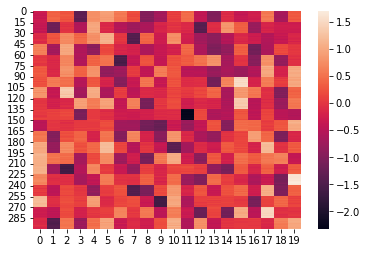

In [31]:
sns.heatmap(trainer_p2v.get_wi())

### Product map

In [32]:
x = trainer_p2v.get_wi()
x /= np.linalg.norm(x, axis=1)[:, np.newaxis]
res_tsne = sklearn.manifold.TSNE(**config_w2v["TSNE"]).fit_transform(x)

In [33]:
res_tsne

array([[ 1.01450035e+02,  1.24134910e+00],
       [ 1.02646492e+02,  2.00566745e+00],
       [ 9.89649734e+01,  4.62200463e-01],
       [ 9.61067810e+01, -2.05089593e+00],
       [ 1.00536888e+02,  3.30402112e+00],
       [ 9.49817123e+01,  2.41297531e+00],
       [ 9.73810501e+01,  2.63033867e+00],
       [ 9.83631134e+01,  3.96629119e+00],
       [ 9.66061249e+01,  1.66423035e+00],
       [ 1.01038986e+02, -2.37952566e+00],
       [ 1.01663292e+02,  4.13743824e-01],
       [ 1.01744400e+02, -1.40758502e+00],
       [ 9.95170059e+01,  1.26274335e+00],
       [ 9.70870590e+01,  9.17303324e-01],
       [ 9.66822128e+01, -1.45345616e+00],
       [ 4.99623032e+01, -3.72595024e+00],
       [ 4.74016190e+01, -1.71258509e+00],
       [ 5.16976318e+01, -4.03261095e-01],
       [ 4.86492844e+01, -3.02414989e+00],
       [ 4.83472939e+01, -1.20011246e+00],
       [ 4.70353203e+01, -4.56852531e+00],
       [ 4.57716599e+01, -4.99788135e-01],
       [ 5.21831131e+01, -1.20721054e+00],
       [ 4.

In [34]:
tsne_map_xy = pd.DataFrame(
    res_tsne,
    index=product[["category", "product"]].set_index(["category", "product"]).index,
    columns=["x", "y"],
).reset_index()

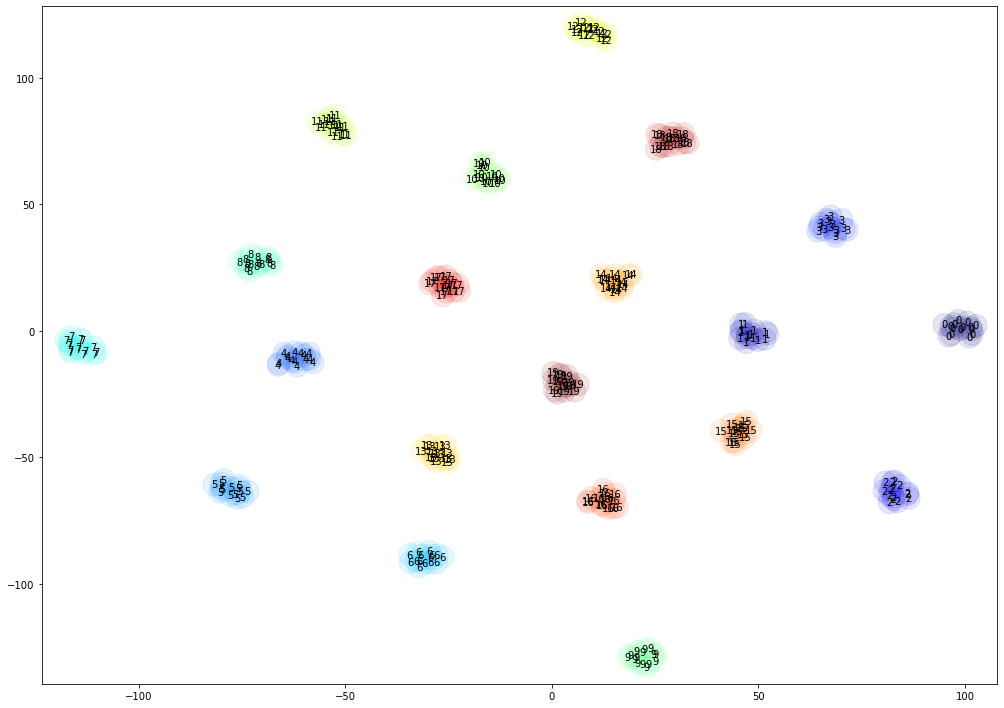

In [35]:
p2vmap.plot_tsne(tsne_map_xy, plotlabels=True, scatter=0)

### Silhouette score

In [38]:
silhouette_score = sklearn.metrics.silhouette_score(
    res_tsne, product['category'].values , metric='euclidean'
)
silhouette_score

0.9046943